In [34]:
# Import PyTorch and related packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Import packages for data manipulation and data splitting
import re
from fuzzywuzzy import process, fuzz

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

# Logging / metrics
# import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

# Downloading datasets, and loading
from sklearn.datasets import fetch_openml

# Other
from collections import deque

In [35]:
# Fetch the 'adult' dataset from OpenML
dataset = fetch_openml(name='SpeedDating', version=1)

# Create a Pandas DataFrame
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                  columns=dataset['feature_names'] + ['target'])

# Display the first few rows
print(df.head())

  has_null wave  gender  age age_o d_age d_d_age  \
0        0    1  female 21.0  27.0     6   [4-6]   
1        0    1  female 21.0  22.0     1   [0-1]   
2        1    1  female 21.0  22.0     1   [0-1]   
3        0    1  female 21.0  23.0     2   [2-3]   
4        0    1  female 21.0  24.0     3   [2-3]   

                                    race  \
0  Asian/Pacific Islander/Asian-American   
1  Asian/Pacific Islander/Asian-American   
2  Asian/Pacific Islander/Asian-American   
3  Asian/Pacific Islander/Asian-American   
4  Asian/Pacific Islander/Asian-American   

                                  race_o samerace  ... expected_num_matches  \
0            European/Caucasian-American        0  ...                  4.0   
1            European/Caucasian-American        0  ...                  4.0   
2  Asian/Pacific Islander/Asian-American        1  ...                  4.0   
3            European/Caucasian-American        0  ...                  4.0   
4               Latino/Hisp

In [36]:
def print_unique_for_column(df, column):
    unique_values = df[column].unique()
    sum = df[column].nunique(dropna=False)
    print(f"Unique values in column '{column}' with sum of {sum} (including NaN): {unique_values}")

def print_unique(df=df):
    # Loop through each column and print unique values
    for column in df.columns:
        print_unique_for_column(df, column)

print_unique(df)

Unique values in column 'has_null' with sum of 2 (including NaN): ['0' '1']
Unique values in column 'wave' with sum of 21 (including NaN): [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21]
Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'age' with sum of 25 (including NaN): [21.0 24.0 25.0 23.0 22.0 26.0 27.0 30.0 28.0 nan 29.0 34.0 35.0 32.0 39.0
 20.0 19.0 18.0 37.0 33.0 36.0 31.0 42.0 38.0 55.0]
Unique values in column 'age_o' with sum of 25 (including NaN): [27.0 22.0 23.0 24.0 25.0 30.0 28.0 21.0 26.0 29.0 nan 39.0 32.0 34.0 35.0
 18.0 20.0 19.0 37.0 33.0 36.0 31.0 42.0 38.0 55.0]
Unique values in column 'd_age' with sum of 35 (including NaN): [6 1 2 3 4 9 7 0 5 8 29 22 27 28 26 21 25 24 12 13 10 17 16 11 14 20 19 18
 32 37 15 34 23 30 36]
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including NaN): ['Asian/Pacific Isl

## Data preprocessing

In [37]:
# Column field has a lot of problems
print(f"Sum: {df['field'].nunique(dropna=True)}")
sorted_unique_values = sorted(df['field'].dropna().unique())
for value in sorted_unique_values:
    print(value)

Sum: 259
Acting
African-American Studies/History
American Studies
American Studies [Masters]
Anthropology
Anthropology/Education
Applied Maths/Econs
Applied Physiology & Nutrition
Architecture
Art Education
Art History
Art History/medicine
Arts Administration
BUSINESS CONSULTING
Bilingual Education
Biochemistry
Biochemistry & Molecular Biophysics
Biology
Biology PhD
Biomedical Engineering
Biomedical Informatics
Biomedical engineering
Biotechnology
Business
Business & International Affairs
Business Administration
Business School
Business [Finance & Marketing]
Business [MBA]
Business and International Affairs [MBA/MIA Dual Degree]
Business- MBA
Business/ Finance/ Real Estate
Business/Law
Business; Media
Business; marketing
Cell Biology
Chemistry
Classics
Climate Dynamics
Climate-Earth and Environ. Science
Clinical Psychology
Cognitive Studies in Education
Communications
Communications in Education
Comparative Literature
Computational Biochemsistry
Computer Science
Conservation biology
Co

In [38]:
# Regular expression to match ;, :, -, /, and everything within []
pattern = r'[;:\-\/]|\[.*?\]'

# Replace matched patterns with an empty string
df['field'] = df['field'].str.replace(pattern, ' ', regex=True)

# Remove phd and remove duplicate space
df['field'] = df['field'].str.replace('phd', '', flags=re.IGNORECASE, regex=True).str.replace(' +', ' ', regex=True)

# Replace shortened engg. with engineering
df['field'] = df['field'].str.replace('engg.', 'engineering', flags=re.IGNORECASE, regex=True)

# Change everything to lowercase and remove white space
df['field'] = df['field'].str.lower().str.strip()
df['race'] = df['race'].str.lower().str.strip()
df['race_o'] = df['race_o'].str.lower().str.strip()

In [39]:
# Define a function to replace close matches
def combine_similar(df, column, correct_value, threshold=90):
    unique_values = df[column].unique()
    
    # Find matches above the threshold
    matches = process.extract(correct_value, unique_values, limit=None, scorer=fuzz.token_sort_ratio)
    close_matches = [match[0] for match in matches if match[1] >= threshold]
    
    # Replace close matches with the correct value
    df[column] = df[column].apply(lambda x: correct_value if x in close_matches else x)

# Mostly used to fix grammatical errors in some strings
combine_similar(df, 'field', 'finance')
combine_similar(df, 'field', 'nutrition')
combine_similar(df, 'field', 'speech language pathology')
combine_similar(df, 'field', 'international affairs')
combine_similar(df, 'field', 'finance economics')
combine_similar(df, 'field', 'mathematic')

In [40]:
# Dropped from 259 values to 203 not including NaN
print(f"Sum: {df['field'].nunique(dropna=True)}")
sorted_unique_values = sorted(df['field'].dropna().unique())
for value in sorted_unique_values:
    print(value)

Sum: 203
acting
african american studies history
american studies
anthropology
anthropology education
applied maths econs
applied physiology & nutrition
architecture
art education
art history
art history medicine
arts administration
bilingual education
biochemistry
biochemistry & molecular biophysics
biochemistry genetics
biology
biomedical engineering
biomedical informatics
biomedicine
biotechnology
business
business & international affairs
business administration
business and international affairs
business consulting
business finance real estate
business law
business marketing
business mba
business media
business school
cell biology
chemistry
classics
climate change
climate dynamics
climate earth and environ. science
clinical psychology
cognitive studies in education
communications
communications in education
comparative literature
computational biochemsistry
computer science
conservation biology
consulting
counseling psychology
creative writing
creative writing nonfiction
curriculum

In [41]:
def try_convert_float(value):
    try:
        return float(value)
    except ValueError:
        return value

# Some columns have numbers in string type so we use his to convert them to float
for column in df.columns:
  df[column] = df[column].apply(try_convert_float)

print_unique(df)

Unique values in column 'has_null' with sum of 2 (including NaN): [0. 1.]
Unique values in column 'wave' with sum of 21 (including NaN): [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]
Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'age' with sum of 25 (including NaN): [21. 24. 25. 23. 22. 26. 27. 30. 28. nan 29. 34. 35. 32. 39. 20. 19. 18.
 37. 33. 36. 31. 42. 38. 55.]
Unique values in column 'age_o' with sum of 25 (including NaN): [27. 22. 23. 24. 25. 30. 28. 21. 26. 29. nan 39. 32. 34. 35. 18. 20. 19.
 37. 33. 36. 31. 42. 38. 55.]
Unique values in column 'd_age' with sum of 35 (including NaN): [ 6.  1.  2.  3.  4.  9.  7.  0.  5.  8. 29. 22. 27. 28. 26. 21. 25. 24.
 12. 13. 10. 17. 16. 11. 14. 20. 19. 18. 32. 37. 15. 34. 23. 30. 36.]
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including

## Filling the NaN values

In [42]:
# Check how much of percentage is missing from every column
missing_values = (df.isnull().sum() / len(df)) * 100

for name, value in missing_values.items():
  print(f"{name}: {value:.2f}%")

has_null: 0.00%
wave: 0.00%
gender: 0.00%
age: 1.13%
age_o: 1.24%
d_age: 0.00%
d_d_age: 0.00%
race: 0.75%
race_o: 0.87%
samerace: 0.00%
importance_same_race: 0.94%
importance_same_religion: 0.94%
d_importance_same_race: 0.00%
d_importance_same_religion: 0.00%
field: 0.75%
pref_o_attractive: 1.06%
pref_o_sincere: 1.06%
pref_o_intelligence: 1.06%
pref_o_funny: 1.17%
pref_o_ambitious: 1.28%
pref_o_shared_interests: 1.54%
d_pref_o_attractive: 0.00%
d_pref_o_sincere: 0.00%
d_pref_o_intelligence: 0.00%
d_pref_o_funny: 0.00%
d_pref_o_ambitious: 0.00%
d_pref_o_shared_interests: 0.00%
attractive_o: 2.53%
sinsere_o: 3.43%
intelligence_o: 3.65%
funny_o: 4.30%
ambitous_o: 8.62%
shared_interests_o: 12.84%
d_attractive_o: 0.00%
d_sinsere_o: 0.00%
d_intelligence_o: 0.00%
d_funny_o: 0.00%
d_ambitous_o: 0.00%
d_shared_interests_o: 0.00%
attractive_important: 0.94%
sincere_important: 0.94%
intellicence_important: 0.94%
funny_important: 1.06%
ambtition_important: 1.18%
shared_interests_important: 1.44%
d

In [43]:
# Column 'expected_num_interested_in_me' has a lot of missing values so we drop it
# We experimented by leaving it in but id did not change any thing
columns_to_drop = ['has_null', 'wave', 'expected_num_interested_in_me']
# columns_to_drop = ['has_null', 'wave', 'target']

df_features = df.drop(columns=columns_to_drop)

In [44]:
# This will select columns with data type 'object' or 'string'
string_columns = df_features.select_dtypes(include=['object', 'string'])

print_unique(string_columns)

Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including NaN): ['asian/pacific islander/asian-american' 'european/caucasian-american'
 'other' 'latino/hispanic american' 'black/african american' nan]
Unique values in column 'race_o' with sum of 6 (including NaN): ['european/caucasian-american' 'asian/pacific islander/asian-american'
 'latino/hispanic american' 'other' 'black/african american' nan]
Unique values in column 'd_importance_same_race' with sum of 3 (including NaN): ['[2-5]' '[6-10]' '[0-1]']
Unique values in column 'd_importance_same_religion' with sum of 3 (including NaN): ['[2-5]' '[0-1]' '[6-10]']
Unique values in column 'field' with sum of 204 (including NaN): ['law' 'economics' 'masters in public administration'
 'masters of social work&education' 'finance' 'business'
 'political science' 'mo

In [45]:
nominal_columns = ['gender', 'race', 'race_o', 'field']
ordinal_columns = string_columns.drop(columns=nominal_columns)

# Encode with one hot encoder
df_encoded = pd.get_dummies(df_features, columns=nominal_columns, drop_first=False)

# Define the order of categories
order = {'[0-1]': 0.0, '[2-3]': 1.0, '[4-6]': 2.0, '[7-37]': 3.0,
         '[0-1]': 0.0, '[2-5]': 1.0, '[6-10]': 2.0,
         '[0-2]': 0.0, '[3-5]': 1.0, '[5-18]': 2.0,
         '[0-3]': 0.0, '[4-9]': 1.0, '[10-20]': 2.0,
         '[0-4]': 0.0, '[5-6]': 1.0, '[7-10]': 2.0,
         '[0-5]': 0.0, '[6-8]': 1.0, '[9-10]': 2.0, 
         '[0-15]': 0.0, '[16-20]': 1.0, '[21-100]': 2.0,
         '[-1-0]': 0.0, '[0-0.33]': 1.0, '[0.33-1]' : 2.0}

# Encode with ordinal encoder
for column in ordinal_columns:
    df_encoded[column] = df_encoded[column].map(order)

In [46]:
# Check if there are any more left
print_unique(df_encoded.select_dtypes(include=['object', 'string']))

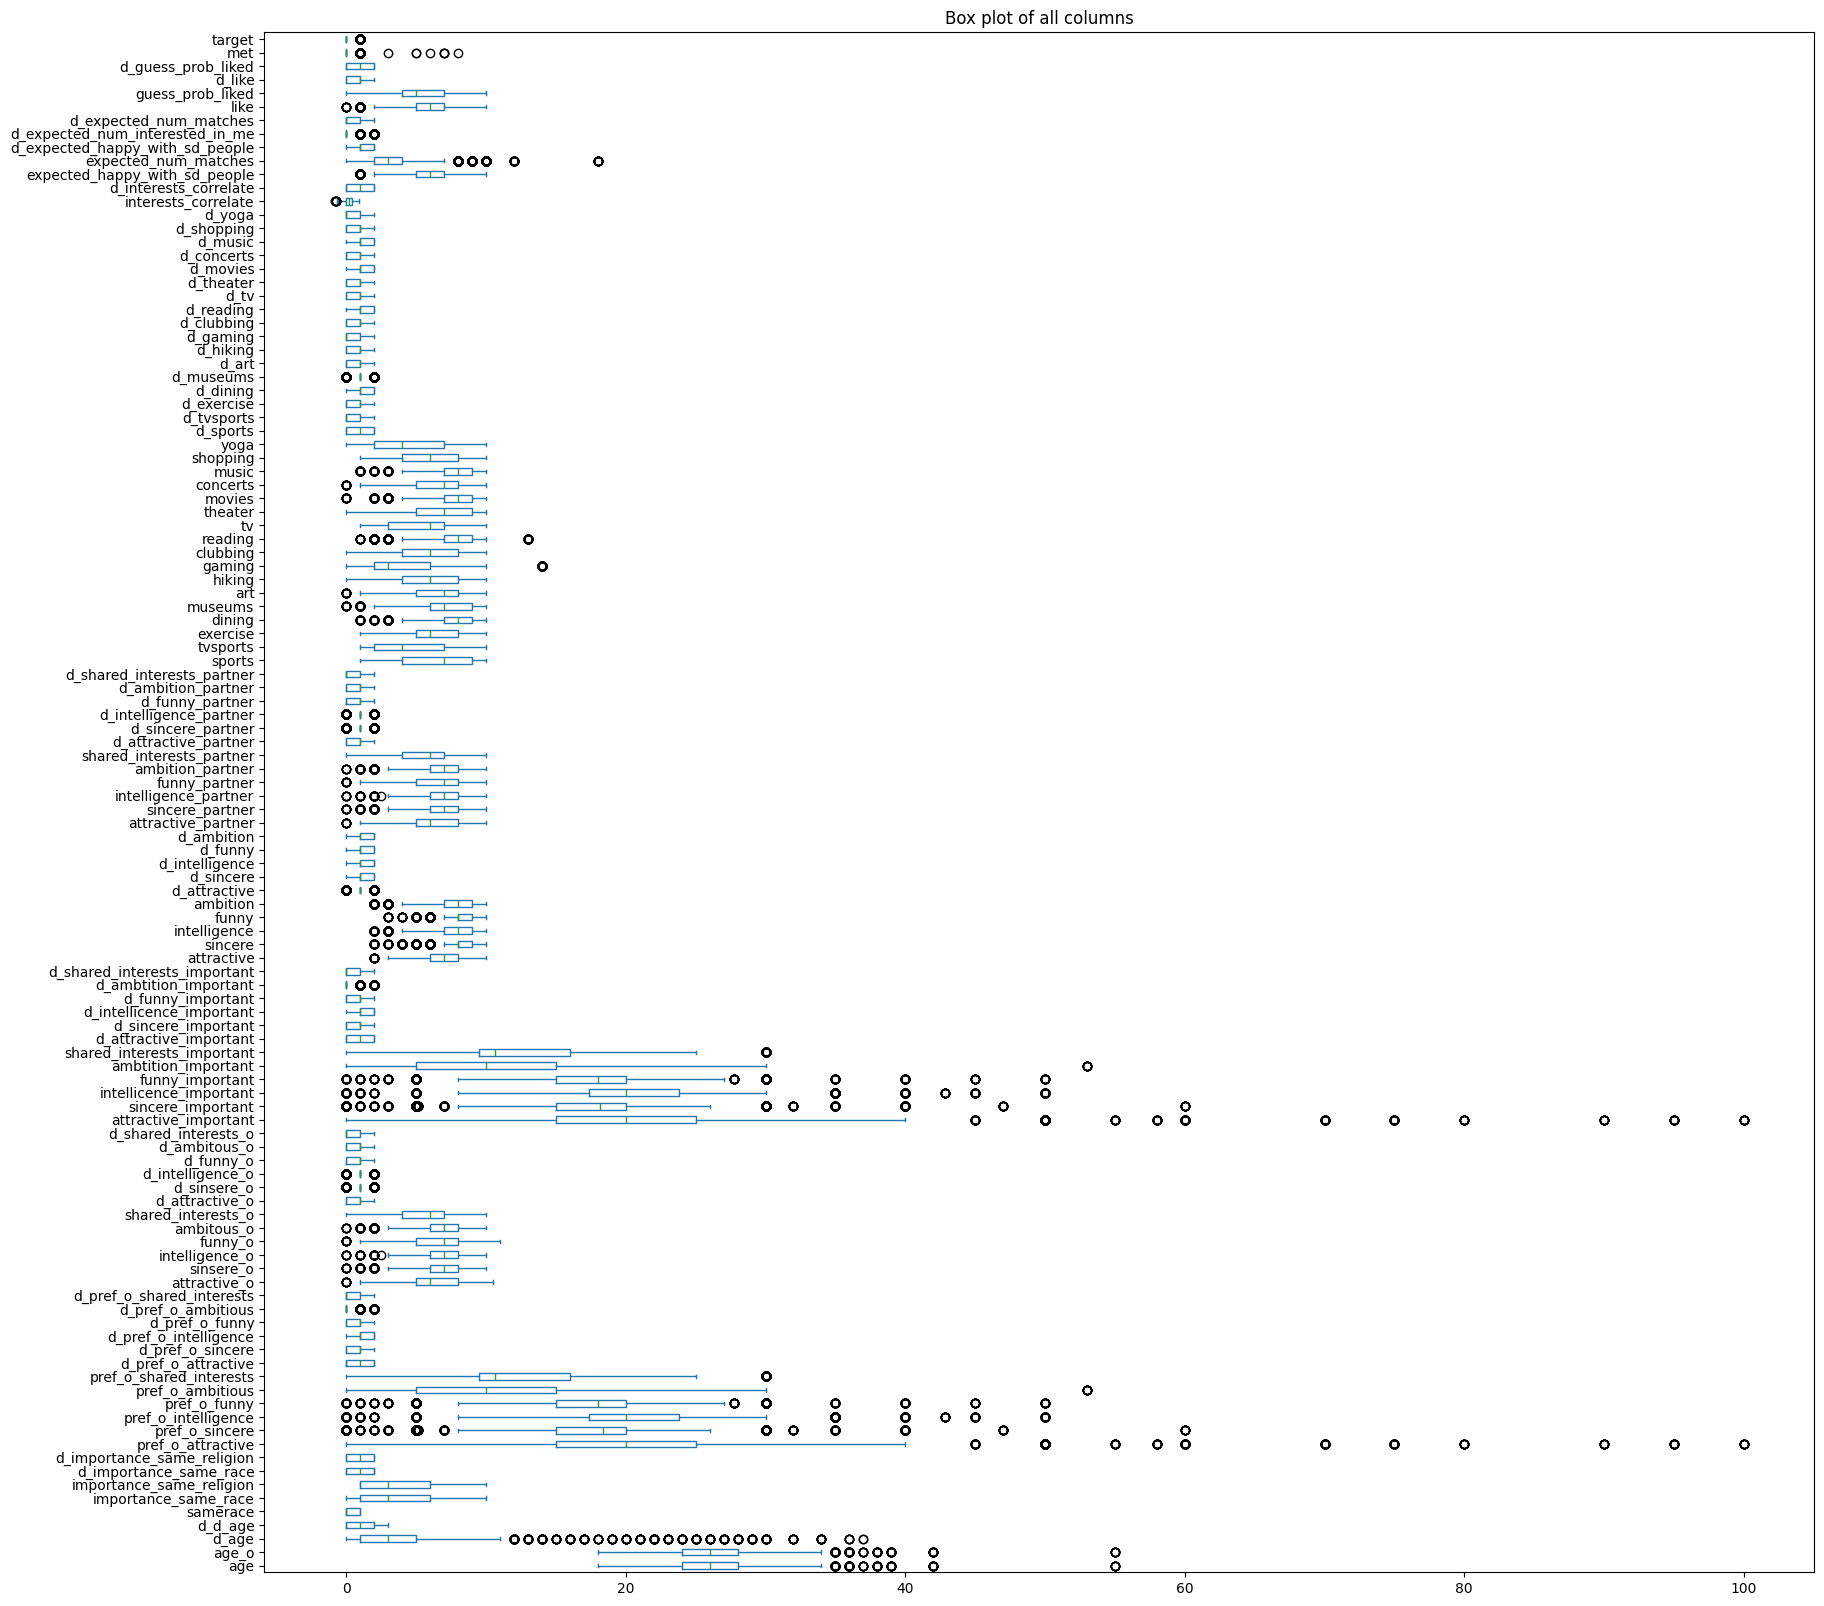

In [47]:
# Plotting box plots to check outliers
df_encoded.plot(kind='box', figsize=(20, 20), vert=False)
plt.title('Box plot of all columns')
plt.show()

In [48]:
# Normalization of data
normalizer = MinMaxScaler()

df_normalized = normalizer.fit_transform(df_encoded)
df_normalized = pd.DataFrame(df_normalized, columns=df_encoded.columns)

In [49]:
# Fill the missing data with KNN
imputer = KNNImputer(n_neighbors=5)

imputed_data = imputer.fit_transform(df_normalized)
clean_data = pd.DataFrame(imputed_data, columns=df_encoded.columns)

Text(0.5, 1.0, 'Mutual Information Scores')

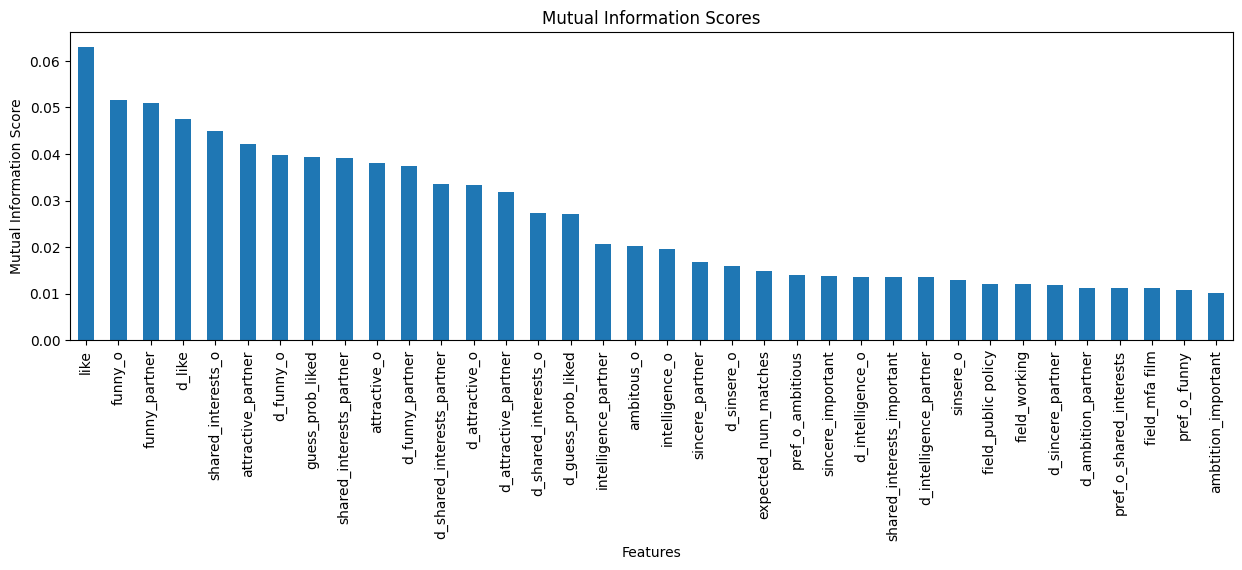

In [50]:
X = clean_data.drop('target', axis=1)
y = clean_data['target']

mic = mutual_info_classif(X, y)

mic_series = pd.Series(mic, index=X.columns)
mic_series = mic_series.sort_values(ascending=False)

# Get only columns that are above the value
mic_series = mic_series[mic_series > 0.01]

mic_series.plot.bar(figsize=(15, 4))
plt.ylabel('Mutual Information Score')
plt.xlabel('Features')
plt.title('Mutual Information Scores')

In [51]:
clean_data = clean_data[mic_series.index.tolist()]
target_data = df['target']
print(f"Data shape is: {clean_data.shape}")

print("Column names: ")
for column in clean_data.items():
  print(column)

Data shape is: (8378, 36)
Column names: 
('like', 0      0.7
1      0.7
2      0.7
3      0.7
4      0.6
        ..
8373   0.2
8374   0.4
8375   0.6
8376   0.5
8377   0.4
Name: like, Length: 8378, dtype: float64)
('funny_o', 0      0.7
1      0.6
2      0.9
3      0.7
4      0.5
        ..
8373   0.2
8374   0.3
8375   0.2
8376   0.5
8377   0.6
Name: funny_o, Length: 8378, dtype: float64)
('funny_partner', 0      0.7
1      0.8
2      0.8
3      0.7
4      0.7
        ..
8373   0.5
8374   0.4
8375   0.8
8376   0.4
8377   0.4
Name: funny_partner, Length: 8378, dtype: float64)
('d_like', 0      0.5
1      0.5
2      0.5
3      0.5
4      0.5
        ..
8373   0.0
8374   0.0
8375   0.5
8376   0.0
8377   0.0
Name: d_like, Length: 8378, dtype: float64)
('shared_interests_o', 0      0.6
1      0.5
2      1.0
3      0.8
4      0.7
        ..
8373   0.5
8374   0.2
8375   0.1
8376   0.6
8377   0.7
Name: shared_interests_o, Length: 8378, dtype: float64)
('attractive_partner', 0      0.6
1      0.

# MLP

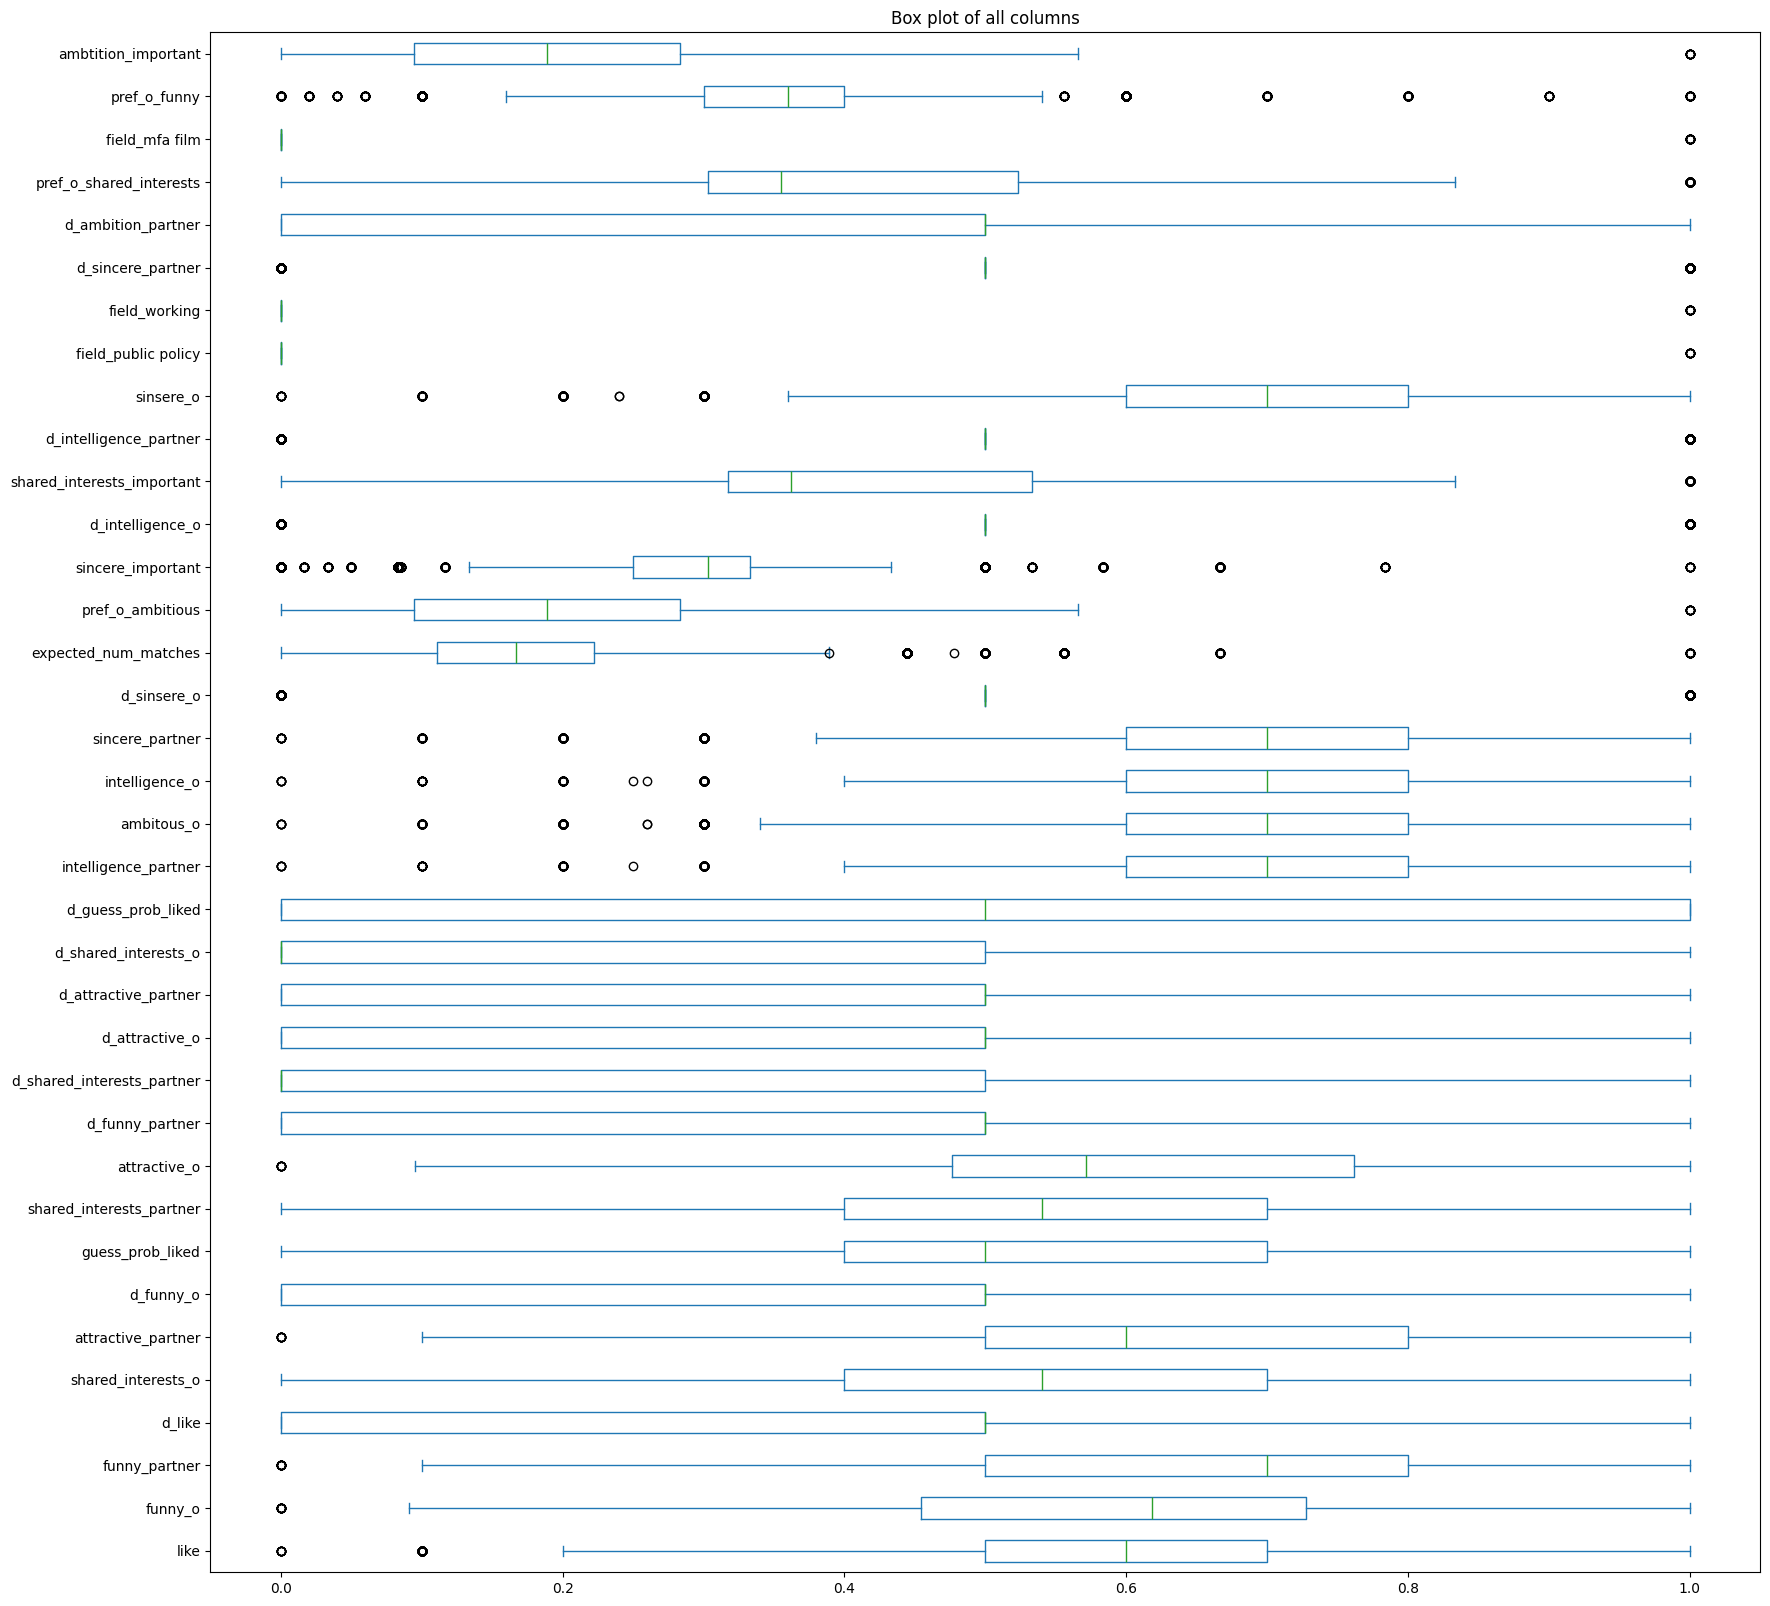

In [52]:
# Plotting box plots to check outliers
clean_data.plot(kind='box', figsize=(20, 20), vert=False)
plt.title('Box plot of all columns')
plt.show()

In [53]:
# Define the feature set X and the target variable y
X = clean_data
y = target_data

# Let's split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

# Verify the shape of each set
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (6702, 36), (6702,)
Test set: (1676, 36), (1676,)


In [54]:
# Convert Pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDataset for each set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Verify the DataLoader objects
for inputs, labels in train_loader:
    print(f"Batch shape: {inputs.shape}, Label shape: {labels.shape}")
    break

Batch shape: torch.Size([64, 36]), Label shape: torch.Size([64])


In [55]:
# If available use GPU instead of CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [56]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size: int = len(clean_data.columns), hidden_size: int = 256, dropout_ratio: float = 0.2):
        super(SimpleMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)

        # Hidden layer
        self.norm1 = nn.BatchNorm1d(hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size)
        self.dropout_layer1 = nn.Dropout(dropout_ratio)

        # Additional hidden layer
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout_layer2 = nn.Dropout(dropout_ratio)

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.leaky_relu(x)

        x = self.hidden_layer1(x) + x
        x = self.norm1(x)
        x = self.dropout_layer1(x)
        x = F.leaky_relu(x)

        x = self.hidden_layer2(x) + x
        x = self.norm2(x)
        x = self.dropout_layer2(x)
        x = F.leaky_relu(x)

        x = self.output_layer(x)
        
        return x

model = SimpleMLP().to(device)
optim = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# loss_fn = F.binary_cross_entropy_with_logits

In [57]:
# Calculate the number of matched and not-matched samples
total_positive_samples = target_data[target_data == 1].count()
total_negative_samples = target_data[target_data == 0].count()

pos_weight = total_negative_samples / total_positive_samples
pos_weight_tensor = torch.tensor(pos_weight).float().to(device)

# Give more importance to the minority class
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

In [58]:
train_losses = deque(maxlen=50)
epochs = 70

for i in range(epochs):
    epoch_train_loss = []

    with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optim.zero_grad()
            out = model(x)
            loss = loss_fn(out, y.unsqueeze(-1))
            loss.backward()
            optim.step()

            train_losses.append(loss.item())
            epoch_train_loss.append(loss.item())

            pbar.set_postfix_str(f"Epoch: {i}, Avg. train loss: {sum(train_losses) / len(train_losses)}")
            pbar.update(1)

    print(f"Epoch Train Loss: {sum(epoch_train_loss) / len(epoch_train_loss)}")

    # Initialize storage for evaluation metrics
    all_probs = []  # Store probabilities for ROC AUC
    all_preds = []  # Store binary predictions for F1
    all_labels = []

    correct = 0
    total = 0
    with torch.inference_mode():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).float()
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            correct += (preds == y.unsqueeze(1)).sum().item()
            total += y.size(0)

    accuracy = correct / total
    print(f"Epoch Accuracy: {accuracy}")
    
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"Epoch ROC AUC Score: {roc_auc}")

    f1 = f1_score(all_labels, np.round(all_preds))
    print(f"Epoch F1 Score: {f1}")

100%|██████████| 105/105 [00:00<00:00, 249.41it/s, Epoch: 0, Avg. train loss: 0.8339844787120819]


Epoch Train Loss: 0.866184743813106
Epoch Accuracy: 0.7309069212410502
Epoch ROC AUC Score: 0.844205486542443
Epoch F1 Score: 0.4983314794215795


100%|██████████| 105/105 [00:00<00:00, 286.88it/s, Epoch: 1, Avg. train loss: 0.8212074339389801]


Epoch Train Loss: 0.8036421060562133
Epoch Accuracy: 0.7392601431980907
Epoch ROC AUC Score: 0.8363742236024845
Epoch F1 Score: 0.5005714285714286


100%|██████████| 105/105 [00:00<00:00, 286.11it/s, Epoch: 2, Avg. train loss: 0.7515168428421021]


Epoch Train Loss: 0.7905077338218689
Epoch Accuracy: 0.7422434367541766
Epoch ROC AUC Score: 0.8464958592132504
Epoch F1 Score: 0.505720823798627


100%|██████████| 105/105 [00:00<00:00, 288.46it/s, Epoch: 3, Avg. train loss: 0.7711044412851333]


Epoch Train Loss: 0.7574212289991833
Epoch Accuracy: 0.7291169451073986
Epoch ROC AUC Score: 0.8421790890269152
Epoch F1 Score: 0.49330357142857145


100%|██████████| 105/105 [00:00<00:00, 279.35it/s, Epoch: 4, Avg. train loss: 0.750716724395752] 


Epoch Train Loss: 0.750690940448216
Epoch Accuracy: 0.7696897374701671
Epoch ROC AUC Score: 0.8444228778467908
Epoch F1 Score: 0.5162907268170426


100%|██████████| 105/105 [00:00<00:00, 283.78it/s, Epoch: 5, Avg. train loss: 0.7327505624294282]


Epoch Train Loss: 0.7477977020399911
Epoch Accuracy: 0.7398568019093079
Epoch ROC AUC Score: 0.848167701863354
Epoch F1 Score: 0.5067873303167421


100%|██████████| 105/105 [00:00<00:00, 284.55it/s, Epoch: 6, Avg. train loss: 0.7419014030694961]


Epoch Train Loss: 0.7281170737175714
Epoch Accuracy: 0.7189737470167065
Epoch ROC AUC Score: 0.8454994824016563
Epoch F1 Score: 0.49625668449197863


100%|██████████| 105/105 [00:00<00:00, 286.10it/s, Epoch: 7, Avg. train loss: 0.7424003487825394]


Epoch Train Loss: 0.7176328202088674
Epoch Accuracy: 0.7315035799522673
Epoch ROC AUC Score: 0.8450051759834368
Epoch F1 Score: 0.49776785714285715


100%|██████████| 105/105 [00:00<00:00, 288.46it/s, Epoch: 8, Avg. train loss: 0.7100523352622986]


Epoch Train Loss: 0.702679777713049
Epoch Accuracy: 0.7523866348448688
Epoch ROC AUC Score: 0.8402639751552795
Epoch F1 Score: 0.4957472660996355


100%|██████████| 105/105 [00:00<00:00, 284.55it/s, Epoch: 9, Avg. train loss: 0.7125616765022278]


Epoch Train Loss: 0.6921444731099266
Epoch Accuracy: 0.7482100238663485
Epoch ROC AUC Score: 0.8504943064182195
Epoch F1 Score: 0.5160550458715596


100%|██████████| 105/105 [00:00<00:00, 286.00it/s, Epoch: 10, Avg. train loss: 0.7104860728979111]


Epoch Train Loss: 0.6949955596810296
Epoch Accuracy: 0.7559665871121718
Epoch ROC AUC Score: 0.8355408902691511
Epoch F1 Score: 0.5136741973840666


100%|██████████| 105/105 [00:00<00:00, 256.10it/s, Epoch: 11, Avg. train loss: 0.6915483516454697]


Epoch Train Loss: 0.6670923343726567
Epoch Accuracy: 0.7511933174224343
Epoch ROC AUC Score: 0.846231884057971
Epoch F1 Score: 0.521239954075775


100%|██████████| 105/105 [00:00<00:00, 255.48it/s, Epoch: 12, Avg. train loss: 0.6652328199148179]


Epoch Train Loss: 0.6563929117861248
Epoch Accuracy: 0.7702863961813843
Epoch ROC AUC Score: 0.8325698757763974
Epoch F1 Score: 0.5095541401273885


100%|██████████| 105/105 [00:00<00:00, 259.26it/s, Epoch: 13, Avg. train loss: 0.6607191157341004]


Epoch Train Loss: 0.6396879054251171
Epoch Accuracy: 0.7607398568019093
Epoch ROC AUC Score: 0.8352587991718425
Epoch F1 Score: 0.5209080047789725


100%|██████████| 105/105 [00:00<00:00, 252.40it/s, Epoch: 14, Avg. train loss: 0.6521866375207901]


Epoch Train Loss: 0.634599727108365
Epoch Accuracy: 0.7458233890214797
Epoch ROC AUC Score: 0.8304451345755695
Epoch F1 Score: 0.505800464037123


100%|██████████| 105/105 [00:00<00:00, 263.55it/s, Epoch: 15, Avg. train loss: 0.6174528104066849]


Epoch Train Loss: 0.6154478198006039
Epoch Accuracy: 0.7488066825775657
Epoch ROC AUC Score: 0.8389233954451346
Epoch F1 Score: 0.5017751479289941


100%|██████████| 105/105 [00:00<00:00, 248.82it/s, Epoch: 16, Avg. train loss: 0.6296805107593536]


Epoch Train Loss: 0.624615542661576
Epoch Accuracy: 0.7684964200477327
Epoch ROC AUC Score: 0.8442003105590062
Epoch F1 Score: 0.5198019801980198


100%|██████████| 105/105 [00:00<00:00, 269.23it/s, Epoch: 17, Avg. train loss: 0.6324420160055161]


Epoch Train Loss: 0.6010020165216355
Epoch Accuracy: 0.7655131264916468
Epoch ROC AUC Score: 0.8406677018633539
Epoch F1 Score: 0.5189718482252142


100%|██████████| 105/105 [00:00<00:00, 291.67it/s, Epoch: 18, Avg. train loss: 0.5984769874811172]


Epoch Train Loss: 0.5781545023123423
Epoch Accuracy: 0.7810262529832935
Epoch ROC AUC Score: 0.8327432712215321
Epoch F1 Score: 0.5190039318479686


100%|██████████| 105/105 [00:00<00:00, 259.26it/s, Epoch: 19, Avg. train loss: 0.6131295895576477]


Epoch Train Loss: 0.5778662931351435
Epoch Accuracy: 0.7601431980906921
Epoch ROC AUC Score: 0.8354865424430641
Epoch F1 Score: 0.5061425061425061


100%|██████████| 105/105 [00:00<00:00, 280.54it/s, Epoch: 20, Avg. train loss: 0.587397655248642] 


Epoch Train Loss: 0.5756247997283935
Epoch Accuracy: 0.7696897374701671
Epoch ROC AUC Score: 0.8360377846790892
Epoch F1 Score: 0.5101522842639594


100%|██████████| 105/105 [00:00<00:00, 247.64it/s, Epoch: 21, Avg. train loss: 0.5591304296255112]


Epoch Train Loss: 0.5512261509895324
Epoch Accuracy: 0.7768496420047732
Epoch ROC AUC Score: 0.8373033126293996
Epoch F1 Score: 0.5155440414507773


100%|██████████| 105/105 [00:00<00:00, 263.82it/s, Epoch: 22, Avg. train loss: 0.5638320899009704]


Epoch Train Loss: 0.529612454346248
Epoch Accuracy: 0.7625298329355609
Epoch ROC AUC Score: 0.829503105590062
Epoch F1 Score: 0.5049751243781094


100%|██████████| 105/105 [00:00<00:00, 257.35it/s, Epoch: 23, Avg. train loss: 0.5211017274856568] 


Epoch Train Loss: 0.5173985955261049
Epoch Accuracy: 0.7696897374701671
Epoch ROC AUC Score: 0.8379865424430641
Epoch F1 Score: 0.5038560411311054


100%|██████████| 105/105 [00:00<00:00, 257.35it/s, Epoch: 24, Avg. train loss: 0.5062833559513092] 


Epoch Train Loss: 0.5070403073515211
Epoch Accuracy: 0.7649164677804295
Epoch ROC AUC Score: 0.8308488612836439
Epoch F1 Score: 0.49872773536895676


100%|██████████| 105/105 [00:00<00:00, 255.38it/s, Epoch: 25, Avg. train loss: 0.521245202422142] 


Epoch Train Loss: 0.49848802174840656
Epoch Accuracy: 0.752983293556086
Epoch ROC AUC Score: 0.8384472049689441
Epoch F1 Score: 0.5035971223021583


100%|██████████| 105/105 [00:00<00:00, 238.64it/s, Epoch: 26, Avg. train loss: 0.5005551213026047]


Epoch Train Loss: 0.4932449113754999
Epoch Accuracy: 0.7774463007159904
Epoch ROC AUC Score: 0.8310481366459627
Epoch F1 Score: 0.5111402359108781


100%|██████████| 105/105 [00:00<00:00, 251.20it/s, Epoch: 27, Avg. train loss: 0.505793741941452] 


Epoch Train Loss: 0.49016364358720327
Epoch Accuracy: 0.795346062052506
Epoch ROC AUC Score: 0.8507168737060041
Epoch F1 Score: 0.5456953642384106


100%|██████████| 105/105 [00:00<00:00, 255.48it/s, Epoch: 28, Avg. train loss: 0.49678519010543826]


Epoch Train Loss: 0.4676234092031206
Epoch Accuracy: 0.7810262529832935
Epoch ROC AUC Score: 0.8259963768115942
Epoch F1 Score: 0.5006802721088436


100%|██████████| 105/105 [00:00<00:00, 247.06it/s, Epoch: 29, Avg. train loss: 0.47275215268135073]


Epoch Train Loss: 0.454272989432017
Epoch Accuracy: 0.7613365155131265
Epoch ROC AUC Score: 0.8304994824016562
Epoch F1 Score: 0.504950495049505


100%|██████████| 105/105 [00:00<00:00, 266.41it/s, Epoch: 30, Avg. train loss: 0.44898316502571106]


Epoch Train Loss: 0.47189119912329175
Epoch Accuracy: 0.7947494033412887
Epoch ROC AUC Score: 0.8335895445134576
Epoch F1 Score: 0.5338753387533876


100%|██████████| 105/105 [00:00<00:00, 247.06it/s, Epoch: 31, Avg. train loss: 0.44082030713558196]


Epoch Train Loss: 0.43379134166808353
Epoch Accuracy: 0.7601431980906921
Epoch ROC AUC Score: 0.8412849378881987
Epoch F1 Score: 0.5024752475247525


100%|██████████| 105/105 [00:00<00:00, 272.73it/s, Epoch: 32, Avg. train loss: 0.4583182406425476] 


Epoch Train Loss: 0.4215054188455854
Epoch Accuracy: 0.7708830548926014
Epoch ROC AUC Score: 0.8338638716356108
Epoch F1 Score: 0.5076923076923077


100%|██████████| 105/105 [00:00<00:00, 277.05it/s, Epoch: 33, Avg. train loss: 0.4355987846851349] 


Epoch Train Loss: 0.4226524057842436
Epoch Accuracy: 0.772673031026253
Epoch ROC AUC Score: 0.8309808488612836
Epoch F1 Score: 0.49934296977660975


100%|██████████| 105/105 [00:00<00:00, 278.51it/s, Epoch: 34, Avg. train loss: 0.4125167632102966] 


Epoch Train Loss: 0.41044408962840123
Epoch Accuracy: 0.801909307875895
Epoch ROC AUC Score: 0.8219099378881987
Epoch F1 Score: 0.5103244837758112


100%|██████████| 105/105 [00:00<00:00, 278.55it/s, Epoch: 35, Avg. train loss: 0.4736479240655899]


Epoch Train Loss: 0.43529293906121025
Epoch Accuracy: 0.772673031026253
Epoch ROC AUC Score: 0.8411878881987578
Epoch F1 Score: 0.5146496815286624


100%|██████████| 105/105 [00:00<00:00, 269.23it/s, Epoch: 36, Avg. train loss: 0.37836181461811064]


Epoch Train Loss: 0.3823677136784508
Epoch Accuracy: 0.7881861575178998
Epoch ROC AUC Score: 0.8411128364389234
Epoch F1 Score: 0.5209176788124157


100%|██████████| 105/105 [00:00<00:00, 277.78it/s, Epoch: 37, Avg. train loss: 0.3977295780181885] 


Epoch Train Loss: 0.37525513349544437
Epoch Accuracy: 0.7959427207637232
Epoch ROC AUC Score: 0.8237396480331264
Epoch F1 Score: 0.5302197802197802


100%|██████████| 105/105 [00:00<00:00, 273.44it/s, Epoch: 38, Avg. train loss: 0.38144354104995726]


Epoch Train Loss: 0.3835322428317297
Epoch Accuracy: 0.7780429594272077
Epoch ROC AUC Score: 0.8335455486542442
Epoch F1 Score: 0.4945652173913043


100%|██████████| 105/105 [00:00<00:00, 286.88it/s, Epoch: 39, Avg. train loss: 0.367359082698822]  


Epoch Train Loss: 0.3633787773904346
Epoch Accuracy: 0.8042959427207638
Epoch ROC AUC Score: 0.8393167701863354
Epoch F1 Score: 0.5176470588235295


100%|██████████| 105/105 [00:00<00:00, 300.23it/s, Epoch: 40, Avg. train loss: 0.34407674670219424]


Epoch Train Loss: 0.3430123238336472
Epoch Accuracy: 0.7959427207637232
Epoch ROC AUC Score: 0.8164958592132505
Epoch F1 Score: 0.48955223880597015


100%|██████████| 105/105 [00:00<00:00, 276.66it/s, Epoch: 41, Avg. train loss: 0.3772821962833405] 


Epoch Train Loss: 0.36119790361041115
Epoch Accuracy: 0.7774463007159904
Epoch ROC AUC Score: 0.8183618012422361
Epoch F1 Score: 0.4925170068027211


100%|██████████| 105/105 [00:00<00:00, 297.45it/s, Epoch: 42, Avg. train loss: 0.35351266115903857]


Epoch Train Loss: 0.35562949705691566
Epoch Accuracy: 0.7696897374701671
Epoch ROC AUC Score: 0.8351501035196687
Epoch F1 Score: 0.5025773195876289


100%|██████████| 105/105 [00:00<00:00, 295.78it/s, Epoch: 43, Avg. train loss: 0.3373373013734817] 


Epoch Train Loss: 0.3442135952767872
Epoch Accuracy: 0.7983293556085919
Epoch ROC AUC Score: 0.8323731884057971
Epoch F1 Score: 0.5087209302325582


100%|██████████| 105/105 [00:00<00:00, 297.45it/s, Epoch: 44, Avg. train loss: 0.3552930870652199] 


Epoch Train Loss: 0.33100966683455874
Epoch Accuracy: 0.7911694510739857
Epoch ROC AUC Score: 0.8331832298136647
Epoch F1 Score: 0.498567335243553


100%|██████████| 105/105 [00:00<00:00, 272.73it/s, Epoch: 45, Avg. train loss: 0.3323948660492897] 


Epoch Train Loss: 0.33054049412409464
Epoch Accuracy: 0.795346062052506
Epoch ROC AUC Score: 0.8194798136645963
Epoch F1 Score: 0.5036179450072359


100%|██████████| 105/105 [00:00<00:00, 296.26it/s, Epoch: 46, Avg. train loss: 0.36052685260772704]


Epoch Train Loss: 0.35837131582555315
Epoch Accuracy: 0.8048926014319809
Epoch ROC AUC Score: 0.8163923395445135
Epoch F1 Score: 0.4992343032159265


100%|██████████| 105/105 [00:00<00:00, 292.48it/s, Epoch: 47, Avg. train loss: 0.32863213658332824]


Epoch Train Loss: 0.3106600121373222
Epoch Accuracy: 0.7780429594272077
Epoch ROC AUC Score: 0.8316563146997928
Epoch F1 Score: 0.515625


100%|██████████| 105/105 [00:00<00:00, 298.29it/s, Epoch: 48, Avg. train loss: 0.31066724777221677]


Epoch Train Loss: 0.2949830879767736
Epoch Accuracy: 0.7965393794749404
Epoch ROC AUC Score: 0.8397787267080746
Epoch F1 Score: 0.5244072524407253


100%|██████████| 105/105 [00:00<00:00, 298.30it/s, Epoch: 49, Avg. train loss: 0.3192597481608391] 


Epoch Train Loss: 0.30677700369131
Epoch Accuracy: 0.7983293556085919
Epoch ROC AUC Score: 0.826493271221532
Epoch F1 Score: 0.4955223880597015


100%|██████████| 105/105 [00:00<00:00, 269.92it/s, Epoch: 50, Avg. train loss: 0.26463305711746216]


Epoch Train Loss: 0.2871991943745386
Epoch Accuracy: 0.7923627684964201
Epoch ROC AUC Score: 0.8232505175983438
Epoch F1 Score: 0.501432664756447


100%|██████████| 105/105 [00:00<00:00, 300.00it/s, Epoch: 51, Avg. train loss: 0.30426955729722976]


Epoch Train Loss: 0.30000911539509184
Epoch Accuracy: 0.8042959427207638
Epoch ROC AUC Score: 0.8310636645962732
Epoch F1 Score: 0.5162241887905604


100%|██████████| 105/105 [00:00<00:00, 281.39it/s, Epoch: 52, Avg. train loss: 0.30196658343076704]


Epoch Train Loss: 0.2865625551768712
Epoch Accuracy: 0.788782816229117
Epoch ROC AUC Score: 0.832815734989648
Epoch F1 Score: 0.5096952908587258


100%|██████████| 105/105 [00:00<00:00, 247.06it/s, Epoch: 53, Avg. train loss: 0.297680549621582]  


Epoch Train Loss: 0.2789177499356724
Epoch Accuracy: 0.795346062052506
Epoch ROC AUC Score: 0.8215838509316771
Epoch F1 Score: 0.4872944693572496


100%|██████████| 105/105 [00:00<00:00, 242.49it/s, Epoch: 54, Avg. train loss: 0.26286588728427884]


Epoch Train Loss: 0.27116218095734007
Epoch Accuracy: 0.8013126491646778
Epoch ROC AUC Score: 0.8374378881987578
Epoch F1 Score: 0.5110132158590308


100%|██████████| 105/105 [00:00<00:00, 240.83it/s, Epoch: 55, Avg. train loss: 0.28060367912054063]


Epoch Train Loss: 0.2630969612371354
Epoch Accuracy: 0.7869928400954654
Epoch ROC AUC Score: 0.8197127329192547
Epoch F1 Score: 0.49647390691114246


100%|██████████| 105/105 [00:00<00:00, 253.07it/s, Epoch: 56, Avg. train loss: 0.240526025891304]  


Epoch Train Loss: 0.24147657099224273
Epoch Accuracy: 0.8186157517899761
Epoch ROC AUC Score: 0.8299741200828157
Epoch F1 Score: 0.5264797507788161


100%|██████████| 105/105 [00:00<00:00, 250.26it/s, Epoch: 57, Avg. train loss: 0.24616264700889587]


Epoch Train Loss: 0.24754794644457953
Epoch Accuracy: 0.801909307875895
Epoch ROC AUC Score: 0.8285507246376812
Epoch F1 Score: 0.5088757396449705


100%|██████████| 105/105 [00:00<00:00, 241.38it/s, Epoch: 58, Avg. train loss: 0.254599749147892]  


Epoch Train Loss: 0.23836666984217508
Epoch Accuracy: 0.8078758949880668
Epoch ROC AUC Score: 0.8323447204968943
Epoch F1 Score: 0.513595166163142


100%|██████████| 105/105 [00:00<00:00, 239.18it/s, Epoch: 59, Avg. train loss: 0.2589850978553295] 


Epoch Train Loss: 0.24838544946341287
Epoch Accuracy: 0.8007159904534606
Epoch ROC AUC Score: 0.8193607660455486
Epoch F1 Score: 0.4954682779456193


100%|██████████| 105/105 [00:00<00:00, 254.85it/s, Epoch: 60, Avg. train loss: 0.27029593378305433]


Epoch Train Loss: 0.2497183237402212
Epoch Accuracy: 0.7852028639618138
Epoch ROC AUC Score: 0.8206314699792961
Epoch F1 Score: 0.4782608695652174


100%|██████████| 105/105 [00:00<00:00, 243.22it/s, Epoch: 61, Avg. train loss: 0.27205557450652124]


Epoch Train Loss: 0.26487807156074616
Epoch Accuracy: 0.8072792362768496
Epoch ROC AUC Score: 0.8152432712215322
Epoch F1 Score: 0.5053598774885145


100%|██████████| 105/105 [00:00<00:00, 244.19it/s, Epoch: 62, Avg. train loss: 0.26073640905320644]


Epoch Train Loss: 0.23781961894461087
Epoch Accuracy: 0.8048926014319809
Epoch ROC AUC Score: 0.8118064182194616
Epoch F1 Score: 0.48665620094191525


100%|██████████| 105/105 [00:00<00:00, 252.40it/s, Epoch: 63, Avg. train loss: 0.2639969674497843] 


Epoch Train Loss: 0.25074108459410216
Epoch Accuracy: 0.7965393794749404
Epoch ROC AUC Score: 0.8317287784679089
Epoch F1 Score: 0.5093525179856115


100%|██████████| 105/105 [00:00<00:00, 225.81it/s, Epoch: 64, Avg. train loss: 0.24105791822075845]


Epoch Train Loss: 0.2369195336387271
Epoch Accuracy: 0.795346062052506
Epoch ROC AUC Score: 0.8248783643892341
Epoch F1 Score: 0.5007278020378457


100%|██████████| 105/105 [00:00<00:00, 251.80it/s, Epoch: 65, Avg. train loss: 0.24685851395130157]


Epoch Train Loss: 0.23602777045397533
Epoch Accuracy: 0.8013126491646778
Epoch ROC AUC Score: 0.838052536231884
Epoch F1 Score: 0.5276595744680851


100%|██████████| 105/105 [00:00<00:00, 256.40it/s, Epoch: 66, Avg. train loss: 0.28140431076288225]


Epoch Train Loss: 0.2828673917622793
Epoch Accuracy: 0.7965393794749404
Epoch ROC AUC Score: 0.8164363354037268
Epoch F1 Score: 0.5007320644216691


100%|██████████| 105/105 [00:00<00:00, 247.06it/s, Epoch: 67, Avg. train loss: 0.2318071584403515] 


Epoch Train Loss: 0.2379187918844677
Epoch Accuracy: 0.801909307875895
Epoch ROC AUC Score: 0.8243478260869564
Epoch F1 Score: 0.47634069400630913


100%|██████████| 105/105 [00:00<00:00, 256.72it/s, Epoch: 68, Avg. train loss: 0.2136829100549221] 


Epoch Train Loss: 0.21324671294007982
Epoch Accuracy: 0.8156324582338902
Epoch ROC AUC Score: 0.8204917184265009
Epoch F1 Score: 0.5149136577708007


100%|██████████| 105/105 [00:00<00:00, 233.85it/s, Epoch: 69, Avg. train loss: 0.21003410145640372]

Epoch Train Loss: 0.21121265547616142
Epoch Accuracy: 0.798926014319809
Epoch ROC AUC Score: 0.8265087991718426
Epoch F1 Score: 0.49925705794947994
